In [1]:
"""This file contains the pipeline for training and evaluating the GCN on the data."""
# %load_ext autoreload
# %autoreload
import os
import sys
import random
import numpy as np
import pandas as pd
import datetime
from typeguard import typechecked

import networkx
import torch
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx
from torch_geometric.utils import to_undirected, add_remaining_self_loops

from sklearn.model_selection import train_test_split

from tqdm import tqdm
sys.path.append("/home/jovyan/20230406_ArticleClassifier/ArticleClassifier")

import src.general.global_variables as gv

sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname('data_loader.py'), os.path.pardir)))
from src.data.data_loader import DataLoader

from src.general.utils import cc_path
from src.models.evaluation import Metrics


import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from src.models.graph_network_models.single_stream_gat import GAT
from src.models.graph_network_models.single_stream_gcn import GCN
from src.models.graph_network_models.single_stream_graphtransformer import GraphTransformer
from src.models.graph_network_models.single_stream_sage import SAGE


from src.models.graph_network_models.dual_stream_gcn import dualGCN
from src.models.graph_network_models.dual_stream_gat import dualGAT


def train(model: torch.nn.Module, data: list[Data], optimizer, criterion):
    """
    Perform one training iteration of the model.

    Args:
        model ():
        data ():
        optimizer ():
        criterion ():

    Returns:

    """
    data_inputs = [d for data_object in data for d in (data_object.x, data_object.edge_index)]

    model.train()
    optimizer.zero_grad()
    out = model(*data_inputs)
    loss = criterion(out[data[0].train_mask], data[0].y[data[0].train_mask])
    loss.backward()
    optimizer.step()
    return loss


def evaluate_metrics(model: torch.nn.Module, data: list[Data], dataset: str = 'test', show: bool = False) -> dict:
    """
    Calculate the different metrics for the specified dataset.

    Args:
        model (torch.nn.Module): The initiated model
        data (Data): The Torch dataset
        dataset (str): The dataset to specify the metrics for

    Returns:
        Dictionary with the metrics
    """
    if dataset == 'test':
        mask = data[0].test_mask
    elif dataset == 'train':
        mask = data[0].train_mask
    else:
        assert False, f'Dataset {dataset} not recognised. Should be "train" or "test".'
    model.eval()

    data_inputs = [d for data_object in data for d in (data_object.x, data_object.edge_index)]

    out = model(*data_inputs)
    pred = out

    metric_calculator = Metrics(pred[mask].detach().numpy(), data[0].y[mask].detach().numpy(),
                                threshold=0.5)
    metrics = metric_calculator.retrieve_all_metrics()
    
    if show:
        print('The metrics: ', metrics)

    return metrics


def plot_metrics_during_training(train_acc_all: list, test_acc_all: list, loss_all: list, model_name: str,
                                 metric_name: str, today, time):
    """
    Plot the evolution of metrics during training

    Args:
        train_acc_all (): the train score over epochs
        test_acc_all (): the test score over epochs
        model_name (): the name of the model

    Returns:
        None
    """


    fig, ax1 = plt.subplots()
    ax1.plot(np.arange(1, len(train_acc_all) + 1), train_acc_all, label='Train accuracy', c='blue')
    ax1.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(metric_name)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Loss')
    ax2.plot(np.arange(1, len(train_acc_all) + 1), loss_all, label='Loss', c='green')

    plt.title(f'{model_name}')
    fig.legend(loc='lower right', fontsize='x-large')
    plt.grid()
    plt.savefig(cc_path(f'reports/figures/classification_results/{today}/{time}/{model_name}_{metric_name}.png'))
    plt.show()


def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()


def get_mask(index: list, size: int) -> torch.Tensor:
    """
    Get a tensor mask of the indices that service as training and test

    Args:
        index ():
        size ():

    Returns:

    """

    mask = np.repeat([False], size)
    mask[index] = True
    mask = torch.tensor(mask, dtype=torch.bool)
    return mask


def make_torch_network(sampled_graph: networkx.classes.graph.Graph, embedding_df: pd.DataFrame,
                       processed_df: pd.DataFrame, train_mask: torch.Tensor, test_mask: torch.Tensor,
                       node_label_mapping: dict, embedding_type: str) -> Data:
    """
    Parse the networkx networks to a torch geometric format with node attributes

    Args:
        sampled_graph (networkx.classes.graph.Graph): A subsampled networkx graph
        embedding_df (pd.DataFrame): dataframe of standardised abstract embeddings
        processed_df (pd.DataFrame): dataframe with the labels
        train_mask (torch.Tensor): indices of train set
        test_mask (torch.Tensor): indices of test set
        node_label_mapping (dict): mapping between pui's and incremental reindexing

    Returns:
        graph dataset in torch geometric format
    """
    
    if embedding_type == 'general' or embedding_type == 'scibert':
        node_features = embedding_df.loc[embedding_df['pui'].isin(sampled_graph.nodes),
                                                               embedding_df.columns.difference(['pui'])].astype(
                                                  np.float32).to_numpy()
    elif embedding_type == 'label_specific':
        node_features = embedding_df.loc[embedding_df['pui'].isin(sampled_graph.nodes),
                                         embedding_df.columns.difference(['pui'])].to_numpy()
    
        reshaped_node_features = np.zeros((len(node_features), len(node_features[0])*len(node_features[0][0])), dtype=np.double)
        for idx, embedding in enumerate(node_features):
            reshaped_node_features[idx, :]  = np.vstack(embedding).flatten()
            
        node_features = (reshaped_node_features - reshaped_node_features.mean())/(reshaped_node_features.std())
        node_features = node_features.astype(np.double)

        # node_features = reshaped_node_features_std.tolist()
        
    # print(node_features)
    
    # set the node attributes (abstracts and labels) in the networkx graph for consistent processing later on
    networkx.set_node_attributes(sampled_graph,
                                 dict(zip(embedding_df.loc[embedding_df['pui'].isin(sampled_graph.nodes),
                                                           'pui'].astype(str).to_list(),
                                          node_features)), 'x')
    networkx.set_node_attributes(sampled_graph,
                                 dict(zip(label_columns.loc[label_columns['pui'].isin(sampled_graph.nodes),
                                                           'pui'].astype(str).to_list(),
                                          label_columns.loc[label_columns['pui'].isin(sampled_graph.nodes),
                                                            label_columns.columns.difference(['pui'])].astype(
                                              np.float32).to_numpy())), 'y')

    # would be nice if this one works, but it sadly doesn't
    # pyg_graph = from_networkx(sampled_graph)

    # x = embedding_df.loc[
    #         embedding_df['pui'].isin(sampled_graph.nodes), embedding_df.columns.difference(['pui'])].astype(np.float32).to_numpy()
    # y = label_columns.loc[
    #         label_columns['pui'].isin(sampled_graph.nodes), label_columns.columns.difference(['pui'])].astype(np.uint8).to_numpy()

    # set the ids at incremental integers.
    sampled_graph = networkx.relabel_nodes(sampled_graph, node_label_mapping)

    # get the x and the y from the networkx graph
    # TODO: enforce order of list for piece of mind
    x = np.array([emb['x'] for (u, emb) in sampled_graph.nodes(data=True)])
    y = np.array([emb['y'] for (u, emb) in sampled_graph.nodes(data=True)])
    edge_weights = np.array([attrs['weight'] for a, b, attrs in sampled_graph.edges(data=True)])

    # create the torch data object for further training
    data = Data(x=torch.from_numpy(x),
                edge_index=torch.from_numpy(np.array(sampled_graph.edges(data=False), dtype=np.int32).T),
                y=torch.from_numpy(y),
                train_mask=train_mask,
                test_mask=test_mask,
                edge_weight=edge_weights)
    
    data.edge_index = to_undirected(data.edge_index)
    data.edge_index, _ = add_remaining_self_loops(data.edge_index)

    return data


def standardise_embeddings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardise the abstract embeddings.
    Args:
        df (pd.DataFrame): dataframe with the embeddings

    Returns:
        standardised embeddings
    """
    df[df.columns.difference(['pui'])] = \
        (df[df.columns.difference(['pui'])] -
         df[df.columns.difference(['pui'])].mean()) / \
        df[df.columns.difference(['pui'])].std()
    return df


def initiate_model(gnn_type, model_parameters, num_features, num_labels):
    if gnn_type == 'GCN':
        model = GCN(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels)
    elif gnn_type == 'GAT':
        model = GAT(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels,
                    heads=model_parameters['heads'])
    elif gnn_type == 'dualGCN':
        model = dualGCN(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                        num_labels=num_labels)
    elif gnn_type == 'dualGAT':
        model = dualGAT(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                        num_labels=num_labels,
                        heads=model_parameters['heads'])
    elif gnn_type == 'SAGE':
        model = SAGE(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
            num_labels=num_labels)
    elif gnn_type == 'GraphTransformer':
        model = GraphTransformer(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels,
                    heads=model_parameters['heads'])    
    
    else:
        assert False, f'Model type: {gnn_type} not recognised, must be in: ["GCN", "GAT", "dualGCN", "dualGAT", "SAGE"]'

    return model

In [2]:
# current models to choose from: ["GCN", "GAT", "dualGCN", "dualGAT"]
# current embedding_types to choose from: ["general", "label_specific"]

gnn_type = 'GAT'
subsample_size = 56337
data_type_to_use = ['author']
embedding_type = 'scibert'

all_model_parameters = {
    "GAT": {
        'hidden_channels': 64,
        'heads': 16
    },
    "GraphTransformer": {
        'hidden_channels': 32,
        'heads': 8
    },
    "GCN": {
        'hidden_channels': 64
    },
    "SAGE": {
        'hidden_channels': 32,
        'heads': 4
    },
    "dualGAT": {
        'hidden_channels': 32,
        'heads': 4
    },
    "dualGCN": {
        'hidden_channels': 32
    },
}

In [6]:
# load all the data
print('Start loading data...')
loc_dict = {
    'processed_csv': cc_path('data/processed/canary/articles_cleaned.csv'),
    'abstract_embeddings': cc_path('data/processed/canary/embeddings_fasttext_20230410.csv'),
    'scibert_embeddings': cc_path('data/processed/canary/embeddings_scibert_20230413.csv'),
    'keyword_network': cc_path('data/processed/canary/keyword_network_weighted.pickle'),
    'xml_embeddings': cc_path('data/processed/canary/embeddings_xml.ftr'),
    'author_network': cc_path('data/processed/canary/author_network.pickle'), 
    'label_network': cc_path('data/processed/canary/label_network_weighted.pickle')
}
data_loader = DataLoader(loc_dict)
processed_df = data_loader.load_processed_csv()
author_networkx = data_loader.load_author_network()
keyword_network = data_loader.load_keyword_network()
label_network = data_loader.load_label_network()

label_data = from_networkx(label_network)

all_data = {
    'author': author_networkx,
    'keyword': keyword_network,
    'label': label_data
}

Start loading data...


In [7]:
# process all data
if embedding_type == 'general':
    embedding_df = data_loader.load_embeddings_csv()
    embedding_df = standardise_embeddings(embedding_df)
elif embedding_type == 'scibert':
    embedding_df = data_loader.load_scibert_embeddings_csv()
    embedding_df = standardise_embeddings(embedding_df)
elif embedding_type == 'label_specific':
    embedding_df = data_loader.load_xml_embeddings()

print('Start processing data...')
print('Standardising embeddings...') 


# process the labels we want to select now

label_columns = processed_df.loc[:, ~processed_df.columns.isin(
    ['file_name', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals',
     'num_refs', 'date-delivered', 'labels_m', 'labels_a'])]

# label_columns = processed_df.loc[:, ['pui', 'human', 'mouse', 'rat', 'nonhuman',
#                                      'controlled study', 'animal experiment']]
label_columns[label_columns.columns.difference(['pui'])] = label_columns[
    label_columns.columns.difference(['pui'])].astype(str)
features = ['file_name', 'pui', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization',
            'chemicals',
            'num_refs', 'date-delivered', 'labels_m', 'labels_a']

# drop all nodes that do not have an embedding
# nodes_to_remove = []
# for network in [author_networkx, keyword_network]:
#     nodes_to_remove += [node for node in list(network.nodes) if not node in embedding_df.pui.to_list()]
#
# for node in nodes_to_remove:
#     for network in [author_networkx, keyword_network]:
#         network.remove_node(node)

Start processing data...
Standardising embeddings...


/tmp/ipykernel_1349/511798419.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_columns[label_columns.columns.difference(['pui'])] = label_columns[


In [8]:
to_remove = [(a,b) for a, b, attrs in keyword_network.edges(data=True) if attrs["weight"] < 1/200]
keyword_network.remove_edges_from(to_remove)

In [9]:
len(list(set(embedding_df.pui.to_list())))

117310

In [10]:
print(len(list(set(author_networkx.nodes) & set(keyword_network.nodes) & set(embedding_df.pui.astype(str).to_list()))))
print(len(list(set(embedding_df.pui.astype(str).to_list()) & set(keyword_network.nodes))))

print(len(author_networkx.nodes))
print(len(keyword_network.nodes))
print(len(author_networkx.edges))
print(len(keyword_network.edges))

56337
96163
71727
97196
163133
542224


In [11]:
# get down-sampled networks
print('Sampling the graphs...')
available_nodes = list(set(author_networkx.nodes) & set(keyword_network.nodes) & set(embedding_df.pui.to_list()))
print('keyword', len(set(keyword_network.nodes)))
print('author', len(set(author_networkx.nodes)))
print('embedding', len(set(embedding_df.pui.to_list())))

sampled_nodes = random.sample(available_nodes, subsample_size)
sampled_author = author_networkx.subgraph(sampled_nodes).copy()
sampled_keyword = keyword_network.subgraph(sampled_nodes).copy()

# nodes can only have incremental integers as labels, so we create a mapping to remember which pui is which idx
node_label_mapping = dict(zip(sampled_author.nodes, range(len(sampled_author))))

Sampling the graphs...
keyword 97196
author 71727
embedding 117310


In [12]:
inverse_node_label_mapping = inv_map = {v: k for k, v in node_label_mapping.items()}


In [13]:
def write_indices_to_txt(indices, data_set):
    # open file in write mode
    with open(cc_path(f'data/{data_set}_indices.txt'), 'w') as fp:
        for item in indices:
            # write each item on a new line
            fp.write("%s\n" % item)
        print('Done')

In [14]:
train_indices, test_indices = train_test_split(range(len(sampled_author)), test_size=0.2, random_state=0)
train_indices, val_indices = train_test_split(range(len(train_indices)), test_size=0.2, random_state=0)

# write_indices_to_txt(list(map(inverse_node_label_mapping.get, train_indices)), data_set='train')
# write_indices_to_txt(list(map(inverse_node_label_mapping.get, test_indices)), data_set='test')
# write_indices_to_txt(list(map(inverse_node_label_mapping.get, val_indices)), data_set='val')

# import json
# with open(cc_path("data/inverse_pui_idx_mapping.json"), "w") as outfile:
#     json.dump(inverse_node_label_mapping, outfile)
    
# with open(cc_path("data/pui_idx_mapping.json"), "w") as outfile:
#     json.dump(node_label_mapping, outfile)

In [15]:
# import json

# with open(cc_path("data/pui_idx_mapping.json"), "r") as outfile:
#     node_label_mapping = json.load(outfile)
    
# with open(cc_path(f'data/train_indices.txt')) as f:
#     train_puis = f.read().splitlines()
#     train_indices = list(map(node_label_mapping.get, train_puis))
# with open(cc_path(f'data/val_indices.txt')) as f:
#     val_puis = f.read().splitlines()
#     val_indices = list(map(node_label_mapping.get, val_puis))
# with open(cc_path(f'data/test_indices.txt')) as f:
#     test_puis = f.read().splitlines()
#     test_indices = list(map(node_label_mapping.get, test_puis))

    

In [16]:
# create train and test split
print('Creating torch datasets...')

train_mask = get_mask(train_indices, len(sampled_author))
test_mask = get_mask(test_indices, len(sampled_author))
author_data = make_torch_network(sampled_author, embedding_df, processed_df, train_mask, test_mask,
                                 node_label_mapping, embedding_type)
keyword_data = make_torch_network(sampled_keyword, embedding_df, processed_df, train_mask, test_mask,
                                  node_label_mapping, embedding_type)

Creating torch datasets...


In [17]:
from torch_geometric.utils import contains_self_loops,is_undirected
is_undirected(author_data.edge_index)

False

In [18]:
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv

class ResidualConnection(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(ResidualConnection, self).__init__()
        self.alpha = alpha

    def forward(self, Xs: list):
        assert len(Xs) >= 1
        return Xs[-1] if len(Xs) == 1 else (1 - self.alpha) * Xs[-1] + self.alpha * Xs[-2]

class InitialConnection(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(InitialConnection, self).__init__()
        self.alpha = alpha

    def forward(self, Xs: list):
        assert len(Xs) >= 1
        return Xs[-1] if len(Xs) == 1 else (1 - self.alpha) * Xs[-1] + self.alpha * Xs[0]
    
class DenseConnection(torch.nn.Module):
    def __init__(self, in_dim, out_dim, aggregation='concat'):
        super(DenseConnection, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.aggregation = aggregation
        if aggregation == 'concat':
            self.layer_transform = torch.nn.Linear(in_dim, out_dim, bias=True)
        elif aggregation == 'attention':
            self.layer_att = torch.nn.Linear(512, 1, bias=True)

    def forward(self, Xs: list):
        assert len(Xs) >= 1
        if self.aggregation == 'concat':
            X = torch.cat(Xs, dim=-1)
            X = self.layer_transform(X)
            return X
        elif self.aggregation == 'maxpool':
            X = torch.stack(Xs, dim=-1)
            X, _ = torch.max(X, dim=-1, keepdim=False)
            return X
        # implement with the code from https://github.com/mengliu1998/DeeperGNN/blob/master/DeeperGNN/dagnn.py
        elif self.aggregation == 'attention':
            # pps n x k+1 x c
            pps = torch.stack(Xs, dim=1)
            retain_score = self.layer_att(pps).squeeze()
            retain_score = torch.sigmoid(retain_score).unsqueeze(1)
            X = torch.matmul(retain_score, pps).squeeze()
            return X
        else:
            raise Exception("Unknown aggregation")

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, num_heads):
        super(GNN, self).__init__()
        self.num_layers = num_layers
        
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATv2Conv(in_channels, hidden_channels, heads=num_heads))
        for i in range(2, num_layers):
            self.convs.append(GATv2Conv(hidden_channels*num_heads, hidden_channels, heads=num_heads))
        self.conv_last = GATv2Conv(hidden_channels*num_heads, out_channels, heads=num_heads)
        
        self.lin1 = torch.nn.Linear(hidden_channels*num_heads, out_channels)
        self.lin2 = torch.nn.Linear(out_channels, out_channels)
        self.sigmoid = torch.nn.Sigmoid()
        # self.skip_layers = DenseConnection(hidden_channels * num_heads * (num_layers-1), out_channels, aggregation='attention')
        self.skip_layers = InitialConnection(alpha=0.5)

        
    def forward(self, x, edge_index):
        xs = []
        x1 = F.dropout(torch.relu(self.convs[0](x, edge_index)), p=0.6, training=self.training)
        xs.append(x1)
        x_new = x1

        for i in range(self.num_layers - 2):
            x_new = F.dropout(torch.relu(self.convs[i+1](x_new, edge_index)), p=0.1, training=self.training)
            xs.append(x_new)
        x_last = self.skip_layers(xs)
        
        x = F.relu(self.lin1(x_last))
        x = self.lin2(x)
        x = self.sigmoid(x)

        return x

    
model = GNN(author_data.x.shape[1], 64, 52, 4, 4)

In [22]:
"""This file defines the GAT single stream model."""

from torch_geometric.nn import GATv2Conv
import torch
import torch.nn.functional as F


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_labels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATv2Conv(num_features, hidden_channels, heads)
        self.conv2 = GATv2Conv(heads * hidden_channels, hidden_channels, heads)
        self.conv3 = GATv2Conv(heads * hidden_channels, hidden_channels, heads)
        self.convend = GATv2Conv(heads * hidden_channels, num_labels, 1)
        
        self.linear_final_1 = torch.nn.Linear(hidden_channels*heads, num_labels*10)
        self.linear_final_2 = torch.nn.Linear(num_labels*10, num_labels*5)
        self.linear_final_3 = torch.nn.Linear(num_labels*5, num_labels)

        # self.self_attention_layer = torch.nn.MultiheadAttention(num_labels, num_heads=1, dropout=0.1)


    def forward(self, x, edge_index):
        x = F.dropout(x.float(), p=0.1, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        # x = F.dropout(x, p=0.1, training=self.training)
        
        # x = F.elu(x)
        # x = F.dropout(x, p=0.2, training=self.training)
        # x = self.conv3(x, edge_index)
        # x = F.elu(x)
        # x = F.dropout(x, p=0.2, training=self.training)
        # x = self.convend(x, edge_index)
        
        x = self.linear_final_1(x)
        x = F.elu(x)

        x = self.linear_final_2(x)
        x = F.elu(x)

        x = self.linear_final_3(x)
        # x, _ = self.self_attention_layer(x, x, x)

        return torch.sigmoid(x)
    
    
# """This file defines the GAT single stream model."""

# from torch_geometric.nn import GATv2Conv
# import torch
# import torch.nn.functional as F


# class GAT(torch.nn.Module):
#     def __init__(self, hidden_channels, num_features, num_labels, heads):
#         super().__init__()
#         torch.manual_seed(1234567)
#         self.conv1 = GATv2Conv(num_features, hidden_channels, heads)
#         self.conv2 = GATv2Conv(heads * hidden_channels, hidden_channels, heads)
#         self.conv3 = GATv2Conv(heads * hidden_channels, hidden_channels, heads)
#         self.convend = GATv2Conv(heads * hidden_channels, num_labels, 1)
        
#         self.self_attention_layer = torch.nn.MultiheadAttention(num_labels, num_heads=1, dropout=0.1)


#     def forward(self, x, edge_index):
#         x = F.dropout(x.float(), p=0.2, training=self.training)
#         x = self.conv1(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, p=0.2, training=self.training)
#         x = self.conv2(x, edge_index)
#         # x = F.elu(x)
#         # x = F.dropout(x, p=0.2, training=self.training)
#         # x = self.conv3(x, edge_index)
#         # x = F.elu(x)
#         # x = F.dropout(x, p=0.2, training=self.training)
#         x = self.convend(x, edge_index)
        
#         x, _ = self.self_attention_layer(x, x, x)

#         return torch.sigmoid(x)

In [23]:
# initiate the model
model = initiate_model(
    gnn_type,
    all_model_parameters[gnn_type],
    num_features=author_data.x.shape[1],
    num_labels=len(label_columns.columns) - 1
)

In [41]:
def new_forward(self, x, edge_index):
    x = F.dropout(x.float(), p=0.1, training=self.training)
    x = self.conv1(x, edge_index)
    x = F.elu(x)
    x = F.dropout(x, p=0.1, training=self.training)
    x = self.conv2(x, edge_index)
    x = F.elu(x)
    
    return x
    # x = F.dropout(x, p=0.1, training=self.training)

    # x = F.elu(x)
    # x = F.dropout(x, p=0.2, training=self.training)
    # x = self.conv3(x, edge_index)
    # x = F.elu(x)
    # x = F.dropout(x, p=0.2, training=self.training)
    # x = self.convend(x, edge_index)

#     x = self.linear_final_1(x)
#     x = F.elu(x)

#     x = self.linear_final_2(x)
#     x = F.elu(x)

#     x = self.linear_final_3(x)
#     # x, _ = self.self_attention_layer(x, x, x)

#     return torch.sigmoid(x)

model.forward = new_forward

In [25]:
model.eval()


all_torch_data = {
    'author': author_data,
    'keyword': keyword_data,
    'label': label_data
}

# get the output of an untrained model
data = [all_torch_data[datatype] for datatype in data_type_to_use]
print('This is the data object: ', data)
data_inputs = [d for data_object in data for d in (data_object.x, data_object.edge_index)]

# model.set_label_embeddings(*data_inputs[3:])

out = model(*data_inputs)
print('The predictions of the test set before training: ', out[author_data.test_mask].detach().numpy())
# visualize(out, color=data.y.argmax(dim=1))

This is the data object:  [Data(x=[56337, 768], edge_index=[2, 223556], y=[56337, 52], train_mask=[56337], test_mask=[56337], edge_weight=[121812])]
The predictions of the test set before training:  [[0.49144393 0.48925364 0.5236177  ... 0.5093796  0.47687754 0.4977704 ]
 [0.48449966 0.4908703  0.49703112 ... 0.5081469  0.478956   0.4912983 ]
 [0.4988181  0.51956546 0.5246152  ... 0.51422316 0.5079952  0.47278002]
 ...
 [0.470775   0.49891827 0.5250968  ... 0.49318215 0.48330316 0.48804227]
 [0.48478875 0.47544026 0.5144056  ... 0.48979366 0.46162388 0.47849518]
 [0.4854114  0.49959168 0.54453355 ... 0.47716063 0.5323564  0.47763216]]


In [26]:
# set training parameters
print('Start training procedure...')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# label_occs = label_columns[label_columns.columns.difference(['pui'])].sum().to_list()
# weight = torch.tensor(label_occs) / sum(label_occs)

criterion = torch.nn.BCELoss()
# criterion = torch.nn.MultiLabelSoftMarginLoss()

Start training procedure...


In [32]:
# train model
all_metrics = evaluate_metrics(model, data, dataset='train').keys()
train_metrics_all = {key: [] for key in all_metrics}
test_metrics_all = {key: [] for key in all_metrics}
loss_all = []

num_epochs = 200
for epoch in (pbar := tqdm(range(1, num_epochs))):
    loss = train(model, data, optimizer, criterion)

    train_metrics = evaluate_metrics(model, data, dataset='train', show=False)
    test_metrics = evaluate_metrics(model, data, dataset='test', show=False)

    for metric in train_metrics.keys():
        train_metrics_all[metric].append(train_metrics[metric])
        test_metrics_all[metric].append(test_metrics[metric])

    loss_all.append(loss.item())
    pbar.set_description(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

print(test_metrics)

Epoch: 199, Loss: 0.1061: 100%|██████████| 199/199 [37:14<00:00, 11.23s/it]

{'Precision': [0.6, 0.775030471878809, 0.6707859614434009, 0.5608899297423887, 0.7878622197922361, 0.7222222222222222, 0.6801393728222996, 1.0, 0.9076682316118936, 0.7514563106796116, 0.7723926380368098, 0.6181818181818182, 0.6159844054580896, 0.0, 0.7440483688121929, 0.6691449814126395, 0.5, 0.6666666666666666, 0.9090909090909091, 0.56, 0.8378208156195874, 0.5, 0.9400970758849295, 0.6724137931034483, 0.7166666666666667, 0.6237980769230769, 0.54, 0.6666666666666666, 0.8008978082915237, 0.8238993710691824, 0.6326530612244898, 0.5, 0.6833060556464812, 0.3, 0.6363636363636364, 0.8644732870510111, 0.6197183098591549, 0.5, 0.0, 0.42857142857142855, 1.0, 0.0, 0.0, 0.6470588235294118, 0.7432432432432432, 0.712166172106825, 0.6814712005551701, 0.6666666666666666, 0.0, 0.8208955223880597, 0.6, 0.2], 'Recall': [0.18117977528089887, 0.8652799377916018, 0.5794192997438087, 0.5480549199084668, 0.8722760290556901, 0.8265895953757225, 0.8, 0.033707865168539325, 0.8467153284671532, 0.4574468085106383,

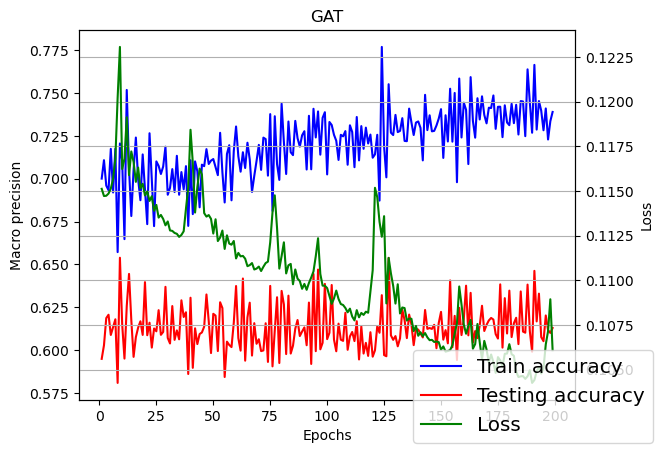

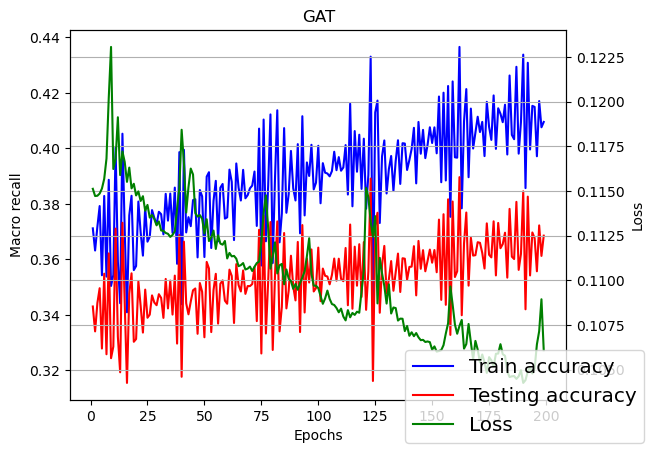

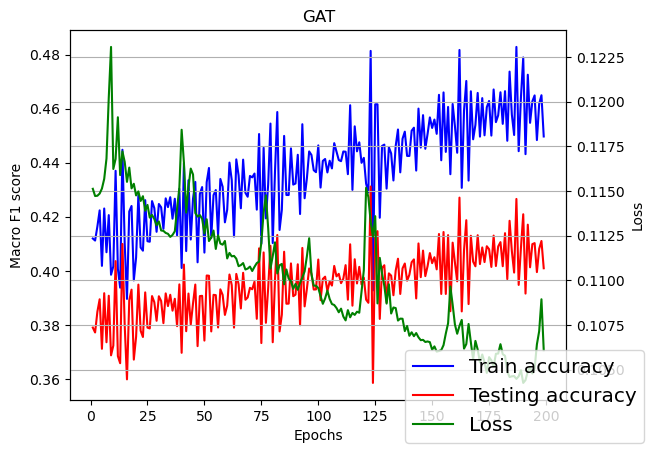

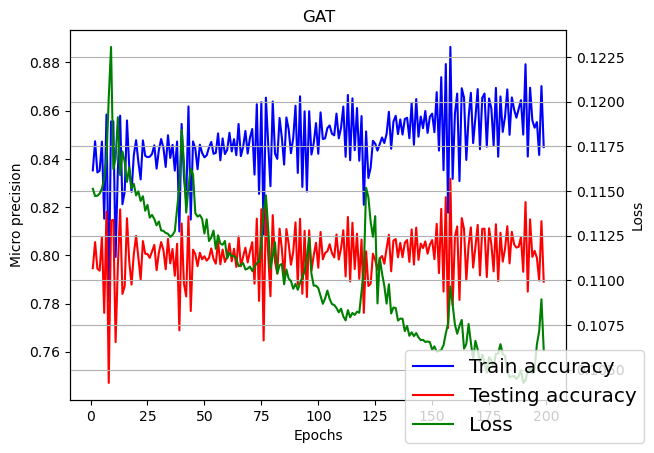

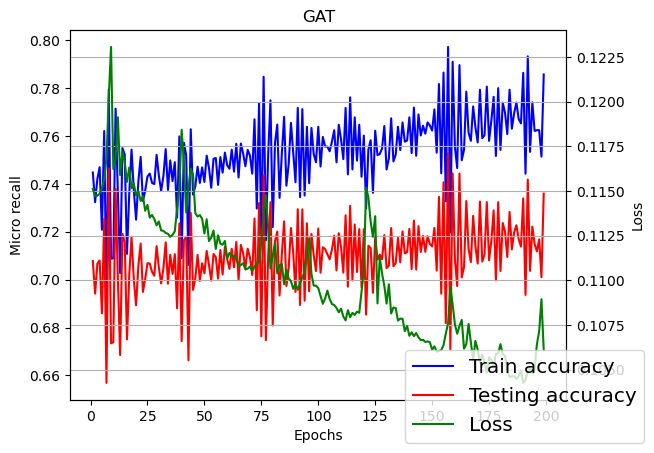

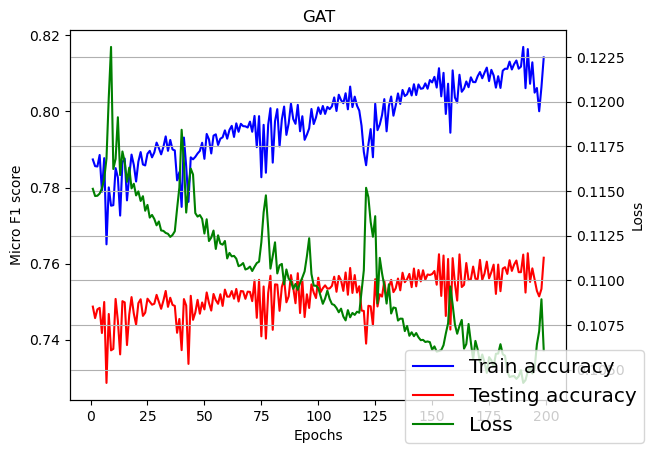

The predictions of the test set before training:  [[1.5980081e-04 3.5528550e-03 2.8345792e-04 ... 5.9404667e-04
  2.3049353e-05 2.0689773e-04]
 [2.6509808e-03 5.9967637e-02 2.7041412e-03 ... 2.1248520e-04
  2.6714409e-04 3.3668093e-03]
 [2.6139682e-02 8.7836289e-01 7.6830858e-01 ... 1.0076517e-02
  4.3957189e-02 6.1166589e-03]
 ...
 [9.4369520e-04 2.0746675e-03 2.7350105e-02 ... 5.7602930e-03
  4.3162392e-03 4.3838183e-04]
 [5.8232556e-04 1.4482802e-03 1.2320446e-04 ... 4.4964600e-04
  2.1612521e-05 2.3758612e-04]
 [7.4617136e-03 8.1853294e-01 6.8599510e-01 ... 1.1868981e-04
  1.0563665e-01 1.0844483e-02]]
Evaluating model performance...
The metrics:  {'Precision': [0.7835051546391752, 0.8268487783642596, 0.7322478516508367, 0.65625, 0.8690849134377576, 0.7912018522416333, 0.7237080233259602, 0.7894736842105263, 0.9583116206357478, 0.8822463768115942, 0.9020910689857339, 0.7559681697612732, 0.6672231496939344, 0.0, 0.7826053373498629, 0.7628742514970059, 0.9, 0.7, 0.8571428571428571, 0

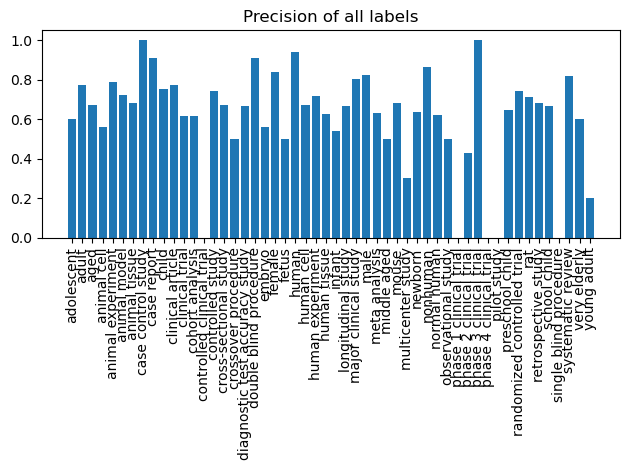

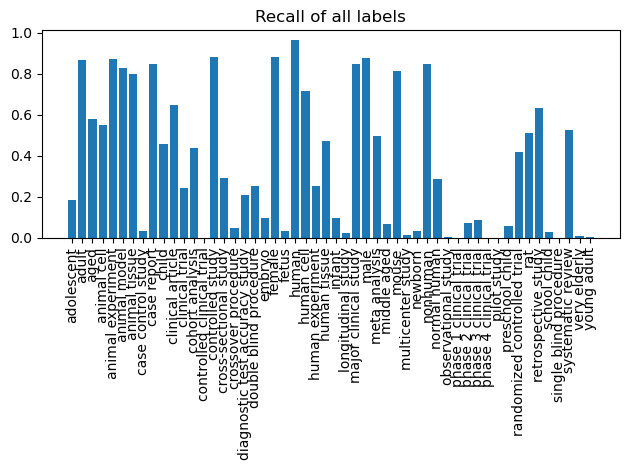

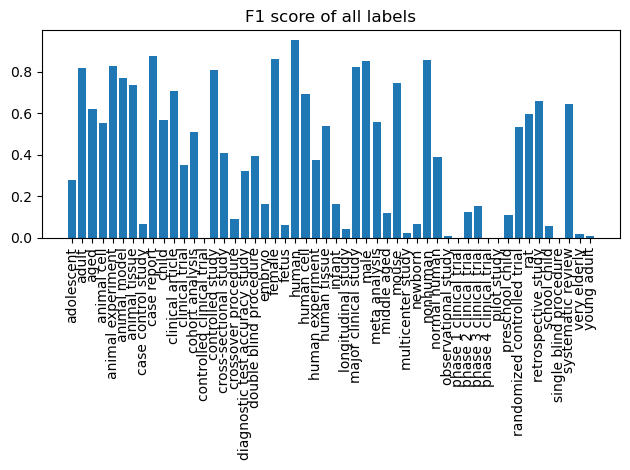

In [33]:
today = datetime.date.today()
now = datetime.datetime.now()
time = now.strftime("%H-%M-%S")

image_path = cc_path(f'reports/figures/classification_results/{today}/')
if not os.path.exists(image_path):
    os.mkdir(image_path)
os.mkdir(image_path + f'{time}/')
for metric in all_metrics:
    if 'Micro' in metric or 'Macro' in metric:
        plot_metrics_during_training(train_metrics_all[metric], test_metrics_all[metric], loss_all, model_name=gnn_type, metric_name=metric, today=today, time=time)


# get output from trained model
model.eval()
out = model(*data_inputs)
print('The predictions of the test set before training: ', out[author_data.test_mask].detach().numpy())

# get the test accuracy
print('Evaluating model performance...')
train_end_metrics = evaluate_metrics(model, data, dataset='train', show=True)
test_end_metrics = evaluate_metrics(model, data, dataset='test', show=True)


for metric in all_metrics:
    if not 'Micro' in metric and not 'Macro' in metric:
        plt.figure()
        plt.title(f'{metric} of all labels')
        plt.bar(range(len(label_columns.columns.difference(['pui']))), test_end_metrics[metric], tick_label=label_columns.columns.difference(['pui']))
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(cc_path(f'reports/figures/classification_results/{today}/{time}/{gnn_type}_{metric}_label.png'))
        plt.show()

# print(f'Test Accuracy: {test_acc:.4f}')

# visualize(out, color=data.y.argmax(dim=1))

In [43]:
data_for_logreg_X, data_for_logreg_y = embedding_df.loc[embedding_df['pui'].isin(sampled_nodes), embedding_df.columns.difference(['pui'])].to_numpy(), \
                                       label_columns.loc[label_columns['pui'].isin(sampled_nodes), label_columns.columns.difference(['pui'])].to_numpy()

In [48]:
data_for_logreg_X_train, data_for_logreg_X_test = data_for_logreg_X[train_indices, :], data_for_logreg_X[test_indices, :]
data_for_logreg_y_train, data_for_logreg_y_test = data_for_logreg_y[train_indices, :].astype(int), data_for_logreg_y[test_indices, :].astype(int)

In [49]:
data_for_logreg_y_train

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0]])

In [50]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
import lightgbm as gbm

clf = OneVsRestClassifier(gbm.LGBMClassifier(n_jobs=-1, n_estimators=500))
clf = clf.fit(data_for_logreg_X_train, data_for_logreg_y_train)


In [51]:
y_test_pred = clf.predict(data_for_logreg_X_test)

In [31]:
from sklearn.metrics import f1_score, recall_score, precision_score
print(f'Macro - F1: {f1_score(data_for_logreg_y_test, y_test_pred, average="macro")}')
print(f'Micro - F1: {f1_score(data_for_logreg_y_test, y_test_pred, average="micro")}')
print(f'Macro - recall: {recall_score(data_for_logreg_y_test, y_test_pred, average="macro")}')
print(f'Micro - recall: {recall_score(data_for_logreg_y_test, y_test_pred, average="micro")}')
print(f'Macro - precision: {precision_score(data_for_logreg_y_test, y_test_pred, average="macro")}')
print(f'Micro - precision: {precision_score(data_for_logreg_y_test, y_test_pred, average="micro")}')

NameError: name 'data_for_logreg_y_test' is not defined

## train lgbm on graph embeddings

In [58]:
graph_created_embeddings = model.forward(model, data_inputs[0], data_inputs[1])
X_train_graph_embeddings = graph_created_embeddings[author_data.train_mask].detach().numpy()
X_test_graph_embeddings = graph_created_embeddings[author_data.test_mask].detach().numpy()
y_train_graph_embeddings = author_data.y[author_data.train_mask].detach().numpy()
y_test_graph_embeddings = author_data.y[author_data.test_mask].detach().numpy()

In [67]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
import lightgbm as gbm

clf = MultiOutputClassifier(gbm.LGBMClassifier(n_jobs=-1, n_estimators=1000))
clf = clf.fit(X_train_graph_embeddings, y_train_graph_embeddings, callbacks = [gbm.log_evaluation()])


In [68]:
y_test_pred = clf.predict(X_test_graph_embeddings)

In [69]:
from sklearn.metrics import f1_score, recall_score, precision_score
print(f'Macro - F1: {f1_score(y_test_graph_embeddings, y_test_pred, average="macro")}')
print(f'Micro - F1: {f1_score(y_test_graph_embeddings, y_test_pred, average="micro")}')
print(f'Macro - recall: {recall_score(y_test_graph_embeddings, y_test_pred, average="macro")}')
print(f'Micro - recall: {recall_score(y_test_graph_embeddings, y_test_pred, average="micro")}')
print(f'Macro - precision: {precision_score(y_test_graph_embeddings, y_test_pred, average="macro")}')
print(f'Micro - precision: {precision_score(y_test_graph_embeddings, y_test_pred, average="micro")}')

Macro - F1: 0.7178392029236375
Micro - F1: 0.849689322396633
Macro - recall: 0.6520048602562387
Micro - recall: 0.8288450494357955
Macro - precision: 0.818377894323753
Micro - precision: 0.8716090490647341


In [56]:
clf[0].best_score_

TypeError: 'OneVsRestClassifier' object is not subscriptable